In [1]:
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import fastprop
import os
from rdkit import Chem
import scipy
from matplotlib import cm
from matplotlib.colors import Normalize 
import seaborn as sns
from sklearn.metrics import mean_squared_error 
from pathlib import Path
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles
from scipy.stats import pearsonr

matplotlib.rcParams.update({'font.style': 'normal'})
matplotlib.rcParams.update({'font.sans-serif': 'Segoe UI'})
matplotlib.rcParams.update({'font.size': 26})

colors = sns.color_palette(palette='Accent').as_hex()


In [2]:
def stats(true, predicted): 
    mse = mean_squared_error(true, predicted)

    differences = np.abs(true - predicted)
    within_1_unit = differences <= 1
    percentage_within_1_unit = np.sum(within_1_unit) / len(true) * 100
    return mse, percentage_within_1_unit

def parity_plot(xs,ys, labels, colors):
    plt.figure(figsize=[6.4,4.8])
    fig, ax1 = plt.subplots()
    ax1.plot([-6, 6], [-6,6], linestyle = '--', linewidth = 2, color = 'black')
    ax1.plot([-6, 6], [-7,5], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
    ax1.plot([-6, 6], [-5,7], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
    for i in range(len(xs)):
        ax1.scatter(xs[i],ys[i], alpha =0.4, s = 30, edgecolors = 'black', color = colors[i], label = labels[i])
    ax1.set_xlim([-5, 2])
    ax1.set_ylim([-5,2])
    ax1.set_ylabel(r"$\hat{logS}$")
    ax1.set_xlabel(r"True $logS$")
    ax1.legend(prop={'size': 20}, loc = 'upper left', frameon = False, bbox_to_anchor=(-0.05,1.1)) 
    ax1.spines[['right', 'top']].set_visible(False)
    return ax1

def solprop_parity_plot(x,y, label, color, mse, percentage_within_1_unit):
    plt.figure(figsize=[6.4,4.8])
    fig, ax1 = plt.subplots()
    ax1.plot([-6, 6], [-6,6], linestyle = '--', linewidth = 2, color = 'black')
    ax1.plot([-6, 6], [-7,5], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
    ax1.plot([-6, 6], [-5,7], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
    ax1.scatter(x,y, alpha =0.4, s = 30, edgecolors = 'black', color = color, label = label)
    ax1.set_xlim([-6,3])
    ax1.set_xticks([-6, -3, 0, 3])
    ax1.set_ylim([-6,3])
    ax1.set_yticks([-6, -3, 0, 3])
    ax1.set_ylabel(r"$\hat{logS}$")
    ax1.set_xlabel(r"True $logS$")
    ax1.legend(prop={'size': 20}, loc = 'upper left', frameon = False, bbox_to_anchor=(-0.05,1.1)) 
    ax1.text(-2,-4.5, f"RMSE = {np.sqrt(mse):.2f}", fontsize = 20)
    ax1.text(-2,-5.5, '% logS' + r'$\pm$'  + f"1 = {percentage_within_1_unit:.1f}", fontsize = 20)
    ax1.spines[['right', 'top']].set_visible(False)
    return ax1

Fastprop performance on Leeds

In [3]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results", "fastprop_5215_predictions")
leeds_acetone: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_acetone_fastprop_predictions.csv"))
leeds_benzene: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_benzene_fastprop_predictions.csv"))
leeds_ethanol: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_ethanol_fastprop_predictions.csv"))

leeds_all_fastprop = pd.concat([leeds_acetone, leeds_benzene, leeds_ethanol], ignore_index=True, axis=0) 

MSE Fastprop= 0.9834289839540981 
Percentage within 1 logS for Fastprop = 70.37037037037037


<Figure size 640x480 with 0 Axes>

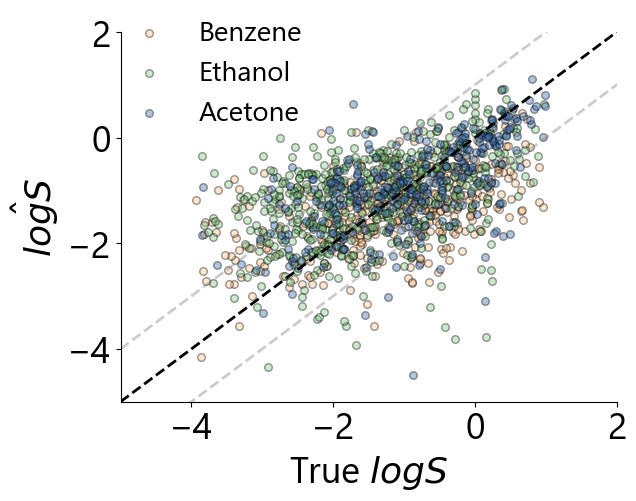

In [4]:
parity_plot([leeds_benzene['logS_true'], leeds_ethanol['logS_true'], leeds_acetone['logS_true']],
            [leeds_benzene['logS_pred'],leeds_ethanol['logS_pred'], leeds_acetone['logS_pred']], 
            ['Benzene', 'Ethanol', 'Acetone'], 
            [colors[2], colors[0], colors[4]])
mse, percentage_within_1_unit = stats(leeds_all_fastprop['logS_true'], leeds_all_fastprop['logS_pred'])
print("MSE Fastprop= " + f"{np.sqrt(mse)}", "\nPercentage within 1 logS for Fastprop = " + f"{percentage_within_1_unit}")

Fastprop performance on Solprop

In [5]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results", "fastprop_5215_predictions")
fastprop_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_fastprop_nonaq_predictions.csv"))
fastprop_predictions[['solvent_smiles', 'solute_smiles']] = fastprop_predictions['smiles'].str.split('.', n=1, expand=True)
solute_smiles = fastprop_predictions.pop('solute_smiles')  
solvent_smiles = fastprop_predictions.pop('solvent_smiles')  

both = fastprop_predictions.pop('smiles')  

fastprop_predictions.insert(0, 'solvent_smiles', solvent_smiles) 
fastprop_predictions.insert(0, 'solute_smiles', solute_smiles) 

<AxesSubplot: xlabel='True $logS$', ylabel='$\\hat{logS}$'>

<Figure size 640x480 with 0 Axes>

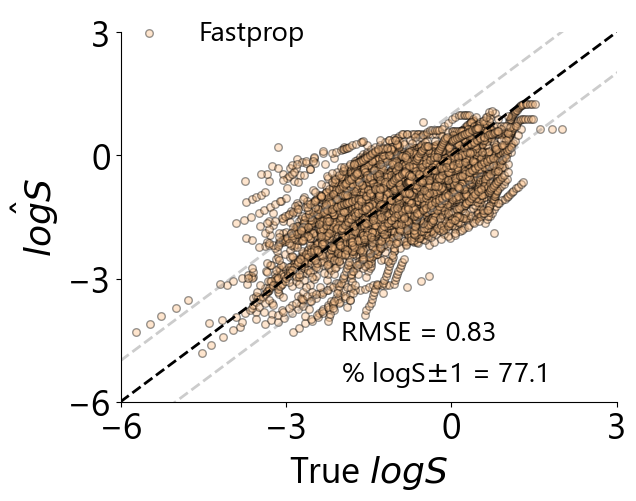

In [6]:
mse_absolute, percentage_within_1_unit = stats(fastprop_predictions['logS_true'], fastprop_predictions['logS_pred'])
solprop_parity_plot(fastprop_predictions['logS_true'],
            fastprop_predictions['logS_pred'],
            'Fastprop', 
            [colors[2]],
            mse_absolute, 
            percentage_within_1_unit)

Chemprop performance on Leeds

In [7]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results", "chemprop_5215_predictions")
leeds_acetone: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_acetone_chemprop_predictions.csv"))
leeds_benzene: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_benzene_chemprop_predictions.csv"))
leeds_ethanol: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_ethanol_chemprop_predictions.csv"))

leeds_all_chemprop = pd.concat([leeds_acetone, leeds_benzene, leeds_ethanol], ignore_index=True, axis=0) 

MSE Chemprop= 0.9408216752354565 
Percentage within 1 logS for Fastprop = 72.14506172839506


<Figure size 640x480 with 0 Axes>

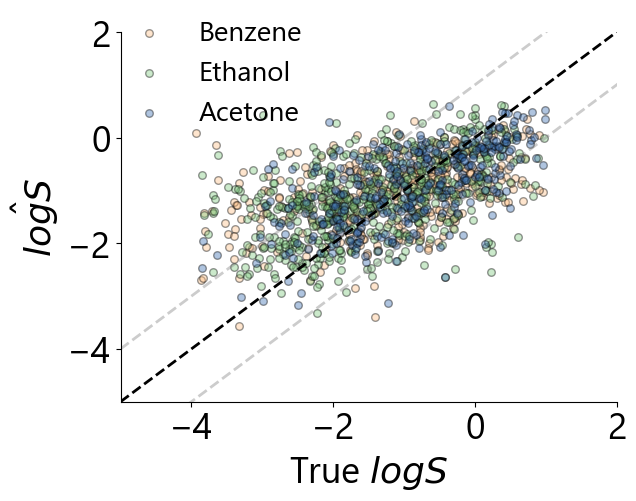

In [8]:
parity_plot([leeds_benzene['logS_true'], leeds_ethanol['logS_true'], leeds_acetone['logS_true']],
            [leeds_benzene['logS_pred'],leeds_ethanol['logS_pred'], leeds_acetone['logS_pred']], 
            ['Benzene', 'Ethanol', 'Acetone'], 
            [colors[2], colors[0], colors[4]])
mse, percentage_within_1_unit = stats(leeds_all_chemprop['logS_true'], leeds_all_chemprop['logS_pred'])
print("MSE Chemprop= " + f"{np.sqrt(mse)}", "\nPercentage within 1 logS for Fastprop = " + f"{percentage_within_1_unit}")

Chemprop performance on Solprop

In [9]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results", "chemprop_5215_predictions")
chemprop_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_chemprop_nonaq_predictions.csv"))

<AxesSubplot: xlabel='True $logS$', ylabel='$\\hat{logS}$'>

<Figure size 640x480 with 0 Axes>

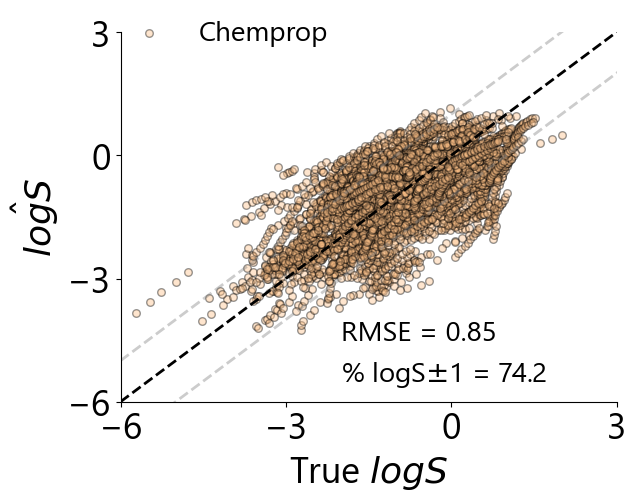

In [10]:
mse_absolute, percentage_within_1_unit = stats(chemprop_predictions['logS_true'], chemprop_predictions['logS_pred'])
solprop_parity_plot(chemprop_predictions['logS_true'],
            chemprop_predictions['logS_pred'],
            'Chemprop', 
            [colors[2]],
            mse_absolute, 
            percentage_within_1_unit)

Residual error analysis

In [11]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results", "fastprop_5215_predictions")
solprop_features: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_fastprop_nonaq.csv"))

In [12]:
merged_fastprop = solprop_features.merge(fastprop_predictions, on=['solute_smiles', 'solvent_smiles', 'temperature'], how='left')
merged_chemprop = solprop_features.merge(chemprop_predictions, on=['solute_smiles', 'solvent_smiles', 'temperature'], how='left')

# Calculate residuals for each model
merged_fastprop['squared_residual'] = (merged_fastprop['logS_true'] - merged_fastprop['logS_pred'])**2
merged_chemprop['squared_residual'] = (merged_chemprop['logS_true'] - merged_chemprop['logS_pred'])**2

In [13]:
def residual_cumsum(merged_fastprop, merged_chemprop, feature):
    
    #sort
    merged_fastprop_sorted_weight = merged_fastprop.sort_values(by=feature)
    merged_chemprop_sorted_weight = merged_chemprop.sort_values(by=feature)

    # Calculate cumulative residuals
    merged_fastprop_sorted_weight['cumulative_residual'] = merged_fastprop_sorted_weight['squared_residual'].cumsum()
    merged_chemprop_sorted_weight['cumulative_residual'] = merged_chemprop_sorted_weight['squared_residual'].cumsum()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(merged_fastprop_sorted_weight[feature], merged_fastprop_sorted_weight['cumulative_residual'], label='Fastprop', color='blue')
    plt.plot(merged_chemprop_sorted_weight[feature], merged_chemprop_sorted_weight['cumulative_residual'], label='Chemprop', color='red')
    plt.title('Cumulative Residuals vs ' + feature)
    plt.xlabel(feature)
    plt.ylabel('Cumulative Residual')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return

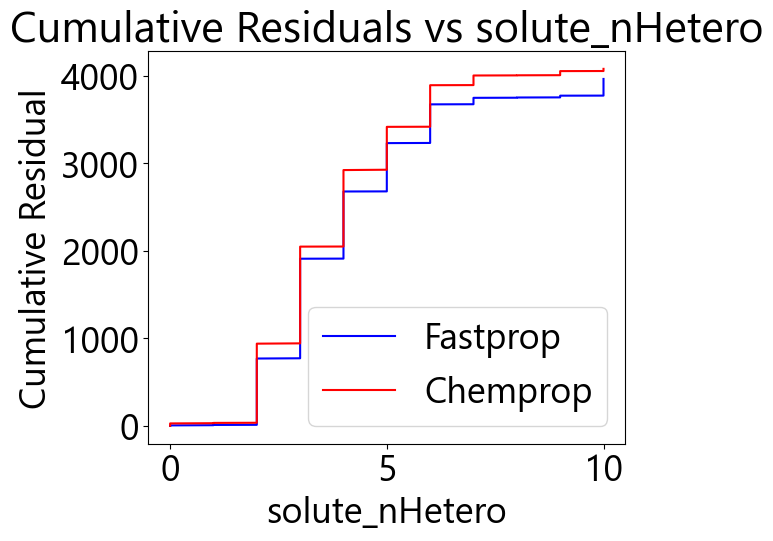

In [14]:
residual_cumsum(merged_fastprop, merged_chemprop, 'solute_nHetero')

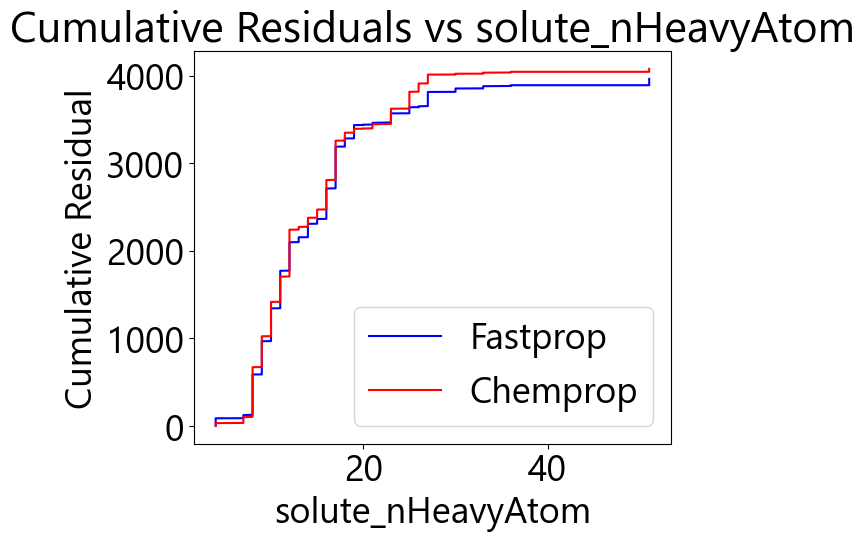

In [15]:
residual_cumsum(merged_fastprop, merged_chemprop, 'solute_nHeavyAtom')

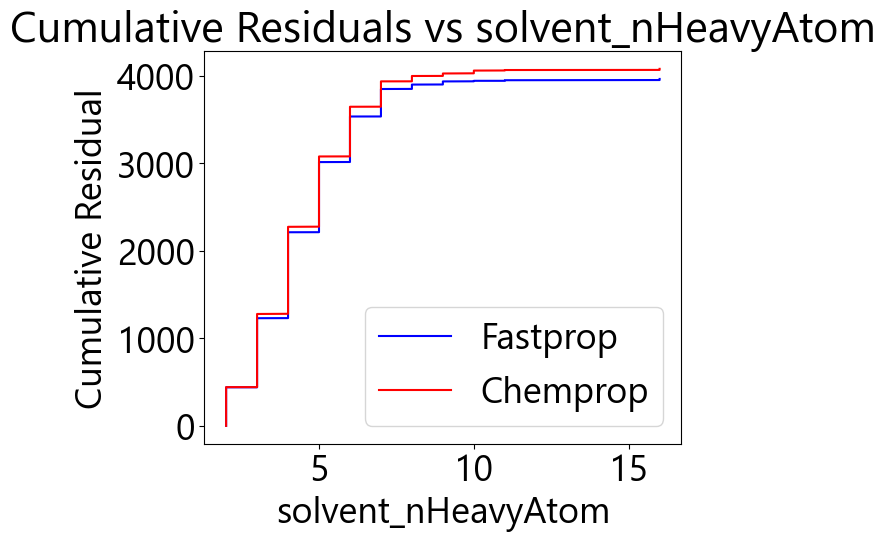

In [16]:
residual_cumsum(merged_fastprop, merged_chemprop, 'solvent_nHeavyAtom')

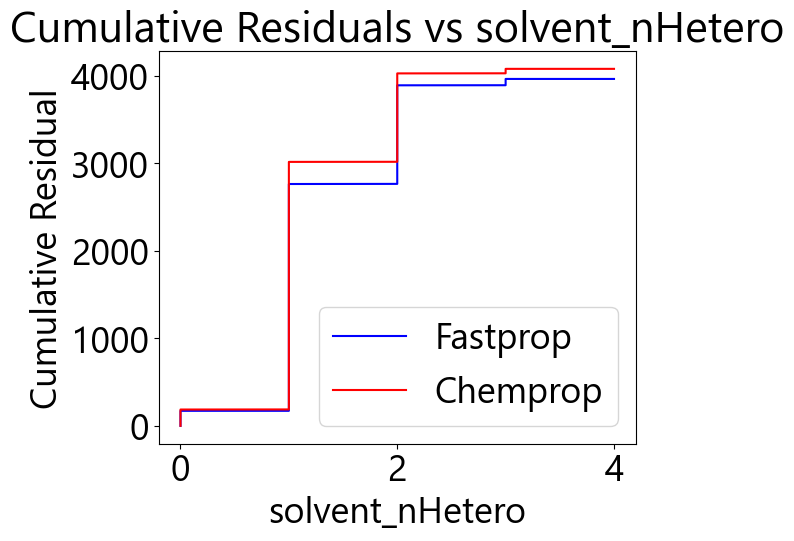

In [17]:
residual_cumsum(merged_fastprop, merged_chemprop, 'solvent_nHetero')


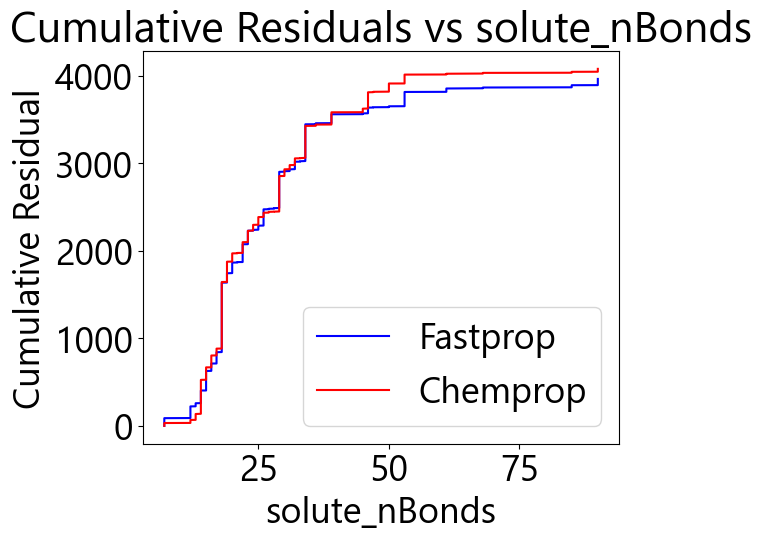

In [18]:
residual_cumsum(merged_fastprop, merged_chemprop, 'solute_nBonds')

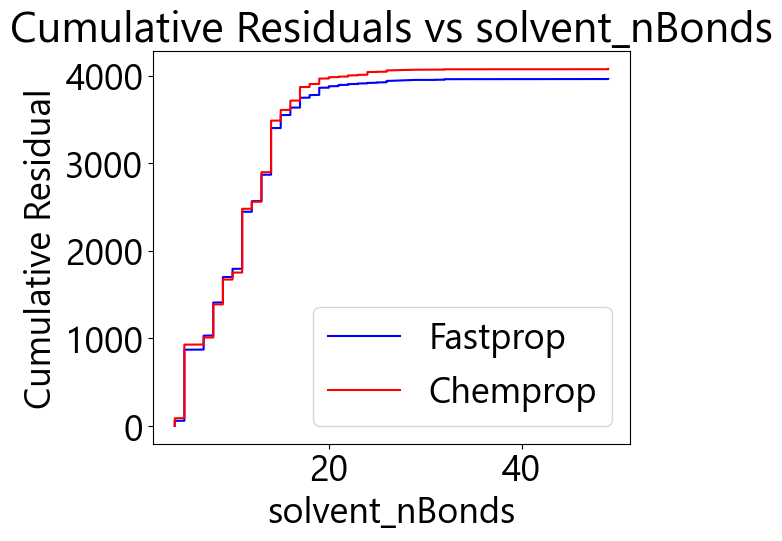

In [19]:
residual_cumsum(merged_fastprop, merged_chemprop, 'solvent_nBonds')

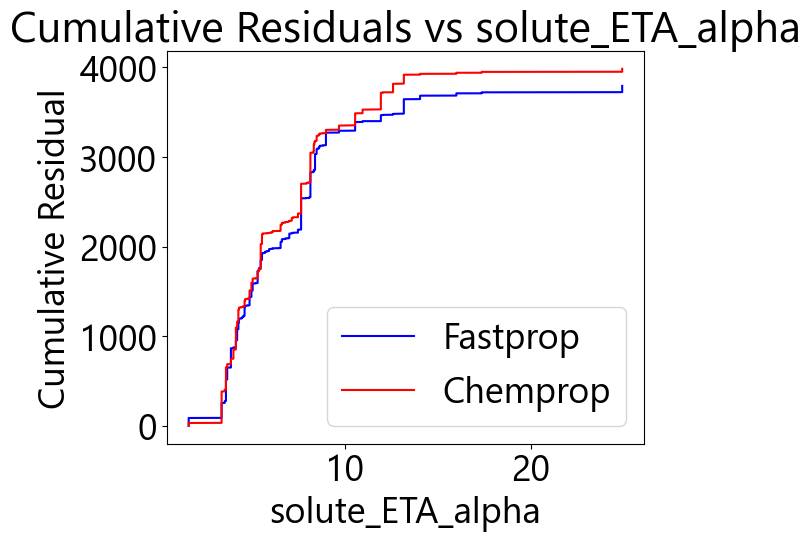

In [20]:
residual_cumsum(merged_fastprop, merged_chemprop, 'solute_ETA_alpha')

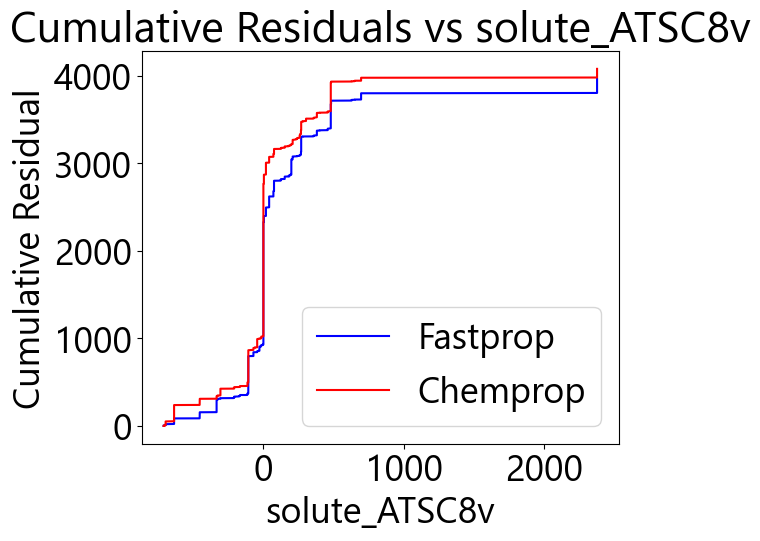

In [21]:
residual_cumsum(merged_fastprop, merged_chemprop, 'solute_ATSC8v')

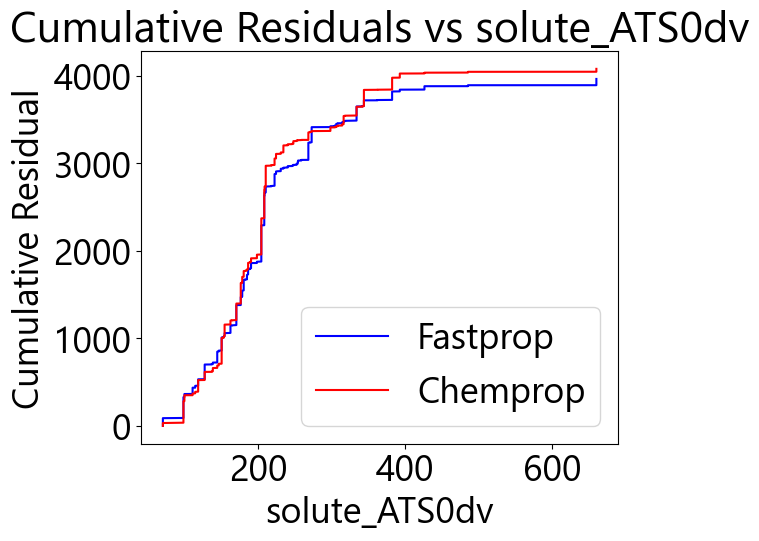

In [22]:
residual_cumsum(merged_fastprop, merged_chemprop, 'solute_ATS0dv')

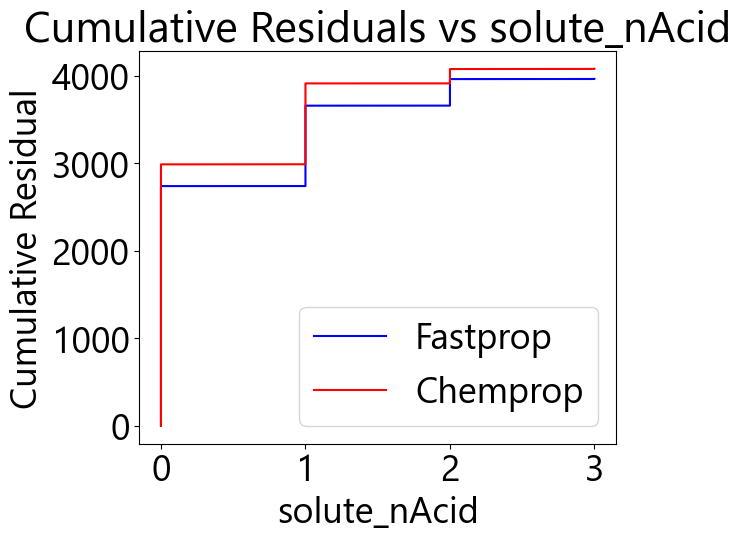

In [23]:
residual_cumsum(merged_fastprop, merged_chemprop, 'solute_nAcid')

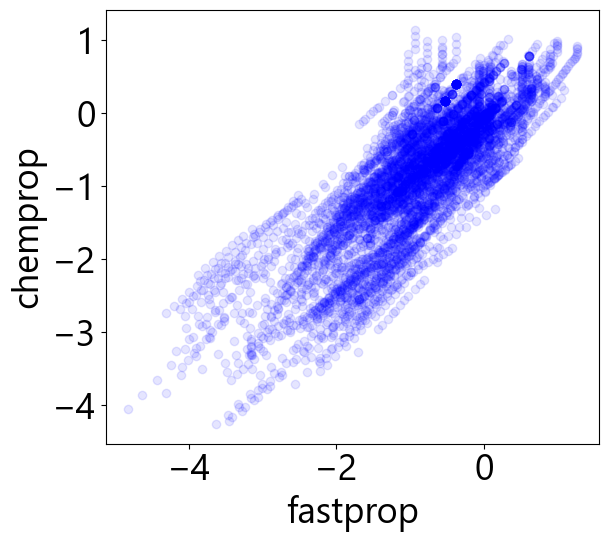

In [24]:

plt.figure(figsize=(12, 6))
r = pearsonr(merged_fastprop['logS_pred'], merged_chemprop['logS_pred'])
plt.subplot(1, 2, 1)
plt.scatter(merged_fastprop['logS_pred'], merged_chemprop['logS_pred'], color='blue', alpha = 0.1)
plt.xlabel('fastprop')
plt.ylabel('chemprop')
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import pearsonr

r = pearsonr(merged_fastprop['logS_pred'], merged_chemprop['logS_pred'])
print(r[0])

In [25]:
from scipy.stats import pearsonr

r = pearsonr(merged_fastprop['logS_pred'], merged_chemprop['logS_pred'])
print(r[0])

0.8112464448118477


In [27]:
from scipy.stats import pearsonr

r = pearsonr(merged_chemprop['logS_pred'], merged_chemprop['logS_true'])
print(r[0])

0.6379489294363208


In [39]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))
def within_1(true, predicted):
    differences = np.abs(true - predicted)
    within_1_unit = differences <= 1
    percentage_within_1_unit = np.sum(within_1_unit) / len(true) * 100
    return percentage_within_1_unit

In [40]:
avg = (merged_fastprop['logS_pred'] + merged_chemprop['logS_pred'])/2
val = rmse(merged_fastprop['logS_true'], avg)

val2 = within_1(merged_fastprop['logS_true'], avg)
print(val)
print(val2)

0.7900562990377457
78.71929824561403
